In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import pickle

In [2]:
import rpy2
import numpy as np

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

import rpy2.ipython.html
rpy2.ipython.html.init_printing()

from rpy2.robjects.packages import importr, data


utils = importr('utils')
base = importr('base')
%load_ext rpy2.ipython

In [3]:
def to_rdf(df):
    with (robjects.default_converter + pandas2ri.converter).context():
        rdf = robjects.conversion.get_conversion().py2rpy(df)
    return rdf

def to_df(rdf):
    with (robjects.default_converter + pandas2ri.converter).context():
        df = robjects.conversion.get_conversion().rpy2py(rdf)

    return df
summary = rpy2.robjects.r['summary']
coef = rpy2.robjects.r['coef']
rprint = rpy2.robjects.r['print']
plot = rpy2.robjects.r['plot']



In [4]:
%%R
R.version.string

[1] "R version 4.2.2 Patched (2022-11-10 r83330)"


In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/dados1/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/dados1/usr/lib/R/site-library’ contains no packages
3: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/dados1/usr/lib/R/site-library’ contains no packages


## Instalar pacotes do R localmente (só para seu usuário)
Talvez é necessário usar
```
utils.install_packages('mirt')
utils.install_packages('mirtCAT')

```
e o equivalente de outros pacotes. Deu erro instalar devtools desta forma, mas consegui instalar no rstudio.atp.usp.br. agora a linha abaixo funciona:

In [5]:
#devtools.install_github('alexandrejaloto/microEnem')

In [6]:
mirt = importr('mirt')
mirtcat = importr("mirtCAT")

In [18]:
ano = 2019
item_info = pd.read_csv(f'../inep/enem/{ano}/DADOS/ITENS_PROVA_{ano}-utf8.csv',sep='\;',engine='python')
item_info.value_counts('TX_MOTIVO_ABAN')


TX_MOTIVO_ABAN
Não permitiu a convergência do algoritmo de estimação da TRI    38
Name: count, dtype: int64

In [91]:
item_info.query('IN_ITEM_ABAN == 1')

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA
20,21,CH,71954,A,5.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,85,NaN
21,22,CH,73447,D,14.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,85,NaN
24,25,CH,58553,C,7.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Azul,85,NaN
66,22,CH,73447,D,14.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarelo,86,NaN
68,24,CH,71954,A,5.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarelo,86,NaN
69,25,CH,58553,C,7.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarelo,86,NaN
109,20,CH,71954,A,5.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branco,87,NaN
111,22,CH,73447,D,14.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branco,87,NaN
114,25,CH,58553,C,7.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Branco,87,NaN
156,22,CH,73447,D,14.0,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Rosa,88,NaN


In [45]:
def load_acertos(ano,area,perc=1,sample=None,remove_abandonados=True):
    '''Retorna os acertos original (da amostra de x %) com os itens mais colunos com as notas_inep e caderno.
     Também retorna e um com somente itens.
    
    Se usar sample, retornar somente sample linhas. Deve dar erro se sample > número de linhas na amostra'''
    df = pd.read_csv(f'data/ac_{perc}_{ano}_{area}.csv',index_col='candidato')
    if sample:
        df = df.sample(sample)
    resp = df.iloc[:,:-3] # assume que as últimas 3 colunas são acertos, nota_inep e caderno 
    if remove_abandonados:
        removed_columns = [col for col in resp.columns if col.endswith('-aban')]
        resp = resp.drop(columns=removed_columns)

    item_info = pd.read_csv(f'../inep/enem/{ano}/DADOS/ITENS_PROVA_{ano}-utf8.csv',sep='\;',engine='python')
    item_info.dropna(subset='CO_ITEM',inplace=True)
    item_info['CO_ITEM'] = item_info['CO_ITEM'].astype(int)
    item_info = item_info[item_info['SG_AREA'] == area]
    item_info = item_info.drop_duplicates(subset='CO_ITEM')
    return df,resp,item_info

df,resp,item_info = load_acertos(2009,'CN',sample=10000,remove_abandonados=False)
resp

,60083,60084,60085,60086,60087,60088,60089,60090,59286,60091,...,60145,60146,60147,58396,59311,60148,60149,60150,60151,60152
candidato,,,,,,,,,,,,,,,,,,,,,
100000772053,1,0,1,1,1,0,1,1,0,1,...,0,0,1,0,0,1,0,0,1,0
100002025493,0,0,0,0,0,1,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1
100002599150,1,0,1,1,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
100001825678,1,1,1,1,1,1,0,0,0,0,...,0,1,0,1,0,1,0,0,0,0
100001195032,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100002888649,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,1,1,0,1,0,1
100000332411,1,1,0,0,1,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
100000817882,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [46]:
def rename_aban(itemname):
    return itemname.strip('-aban')

def item_stats(ano,area):
    acertos, resp, item_info = load_acertos(ano, area, sample=10000,remove_abandonados=False)
    resp.rename(columns=rename_aban,inplace=True)
    istats = mirt.itemstats(to_rdf(resp))
    istats = to_df(istats[1])
    #istats.index = istats.index.astype(int)
    #istats.index = istats.index
    item_info = item_info.drop_duplicates(subset=['CO_ITEM'],keep='first')
    item_info = item_info.set_index('CO_ITEM')
    item_info.index = item_info.index.astype(str)
    istats = pd.merge(istats,item_info,how='left',left_index=True,right_index=True,validate='1:m')
    istats = istats.drop(columns=['CO_HABILIDADE'])
    return istats
istats = item_stats(2019,'CN')
istats.sort_values('total.r',ascending=True)

,N,mean,sd,total.r,total.r_if_rm,alpha_if_rm,CO_POSICAO,SG_AREA,TX_GABARITO,IN_ITEM_ABAN,TX_MOTIVO_ABAN,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
14273,10000,0.0952,0.293506,0.028703,-0.031241,0.655205,106,CN,D,0,NaN,3.90297,2.19782,0.05798,Amarela,504,NaN,0
97169,10000,0.1319,0.338399,0.050762,-0.018374,0.655536,107,CN,A,0,NaN,5.93339,1.98881,0.13188,Amarela,504,NaN,0
83441,10000,0.1378,0.344707,0.054424,-0.016001,0.655549,106,CN,D,0,NaN,4.60881,1.94111,0.12462,Azul,503,NaN,0
83609,10000,0.2989,0.457799,0.080844,-0.012699,0.658090,98,CN,E,1,Não permitiu a convergência do algoritmo de es...,NaN,NaN,NaN,Amarela,504,NaN,0
54381,10000,0.1106,0.313652,0.081175,0.017168,0.653342,96,CN,A,0,NaN,3.20714,2.14905,0.08067,Rosa,506,NaN,0
111601,10000,0.2283,0.419758,0.087548,0.001822,0.656181,91,CN,B,0,NaN,7.09582,2.42384,0.23686,Amarela,504,NaN,0
117868,10000,0.4984,0.500022,0.094260,-0.007901,0.658930,114,CN,E,0,NaN,0.05808,8.96186,0.22071,Amarela,504,NaN,0
78504,10000,0.1917,0.393658,0.095918,0.015586,0.654786,108,CN,C,0,NaN,3.20779,1.67408,0.16383,Azul,503,NaN,0
49600,10000,0.1703,0.375915,0.129327,0.052920,0.652324,108,CN,D,0,NaN,1.14904,2.36402,0.11480,Amarela,504,NaN,0
111545,10000,0.2509,0.433553,0.139093,0.050972,0.653283,92,CN,E,0,NaN,0.54124,3.79854,0.17374,Amarela,504,NaN,0


In [30]:
def load_model(ano,area,itemtype="3PL", method="EM", SE=True,remove_b=None):
    if remove_b:
        fn = f'data/models/model-{ano}-{area}-{itemtype}-{method}-b{remove_b}'
    else:
        fn = f'data/models/model-{ano}-{area}-{itemtype}-{method}'
    
    with open(fn,'rb') as pfile:
        model = pickle.load(pfile)
    return model

def estimate_irt(ano,area,itemtype="3PL", method="EM", SE=True,remove_b=None,write_model=True):
    'Estime o modelo. Se já foi estimado, e remove_b é dado, remova itens com abs(b) < remove_b e a < 0'
    df,resp,item_info = load_acertos(ano,area)
    
    if remove_b:
        model = load_model(ano,area,itemtype, method, SE)
        coefs = irt_coefs(model)
        resp.columns = resp.columns.astype(int)
        items_to_remove = coefs.query(f'abs(b) > {remove_b} | a < 0').index
        if len(items_to_remove) > 0:
            resp = resp.drop(columns=items_to_remove)
            print("removing items", coefs.query(f'b > {remove_b}').index)
            model = mirt.mirt(to_rdf(resp),1,itemtype=itemtype,method=method,SE=SE)
            fn = f'data/models/model-{ano}-{area}-{itemtype}-{method}-b{remove_b}'
        else:
            print("No items do remove!")
            return 
    else:
        model = mirt.mirt(to_rdf(resp),1,itemtype=itemtype,method=method,SE=SE)
        fn = f'data/models/model-{ano}-{area}-{itemtype}-{method}'
    if write_model:
        with open(fn, 'wb') as pfile:
            pickle.dump(model,pfile)
        
    return model


for ano in range(2009,2023):
    for area in ['MT','CN','CH']:
        print(f"Ano = {ano}, area = {area}") 
        #_ = estimate_irt(ano,area)
        #_ = estimate_irt(ano,area,remove_b=5)

Ano = 2009, area = MT
Ano = 2009, area = CN
Ano = 2009, area = CH
Ano = 2010, area = MT
Ano = 2010, area = CN
Ano = 2010, area = CH
Ano = 2011, area = MT
Ano = 2011, area = CN
Ano = 2011, area = CH
Ano = 2012, area = MT
Ano = 2012, area = CN
Ano = 2012, area = CH
Ano = 2013, area = MT
Ano = 2013, area = CN
Ano = 2013, area = CH
Ano = 2014, area = MT
Ano = 2014, area = CN
Ano = 2014, area = CH
Ano = 2015, area = MT
Ano = 2015, area = CN
Ano = 2015, area = CH
Ano = 2016, area = MT
Ano = 2016, area = CN
Ano = 2016, area = CH
Ano = 2017, area = MT
Ano = 2017, area = CN
Ano = 2017, area = CH
Ano = 2018, area = MT
Ano = 2018, area = CN
Ano = 2018, area = CH
Ano = 2019, area = MT
Ano = 2019, area = CN
Ano = 2019, area = CH
Ano = 2020, area = MT
Ano = 2020, area = CN
Ano = 2020, area = CH
Ano = 2021, area = MT
Ano = 2021, area = CN
Ano = 2021, area = CH
Ano = 2022, area = MT
Ano = 2022, area = CN
Ano = 2022, area = CH


In [31]:
ano, area = 2009, 'CH'
df,resp,item_info = load_acertos(ano,ar sea,)
len(resp.columns)

45

In [32]:
s = '''
F = 1-43
PRIOR = (1-43,d,norm, 0, 2)
PRIOR = (1-43,a1,lnorm, .2, .2)
START = (1-43,g,0.2)
FIXED = (1-43,g)
'''

In [33]:
s = '''
F = 1-45
PRIOR = (1-45,d,norm, 0, 10)
PRIOR = (1-45,a1,lnorm, .2, .5)
'''
mirtmodel = mirt.mirt_model(s)
#mirtmodel = mirt.mirt_model("1")
model = mirt.mirt(to_rdf(resp),mirtmodel,itemtype='3PL',method='EM',SE=False)

Iteration: 76, Log-Lik: -596259.952, Max-Change: 0.00293


In [34]:
irtparams = pd.merge(irt_coefs(model),item_info.set_index('CO_ITEM'),left_index=True,right_index=True)
fig, axs = plt.subplots(1,2,figsize=(16,6))
ax1,ax2 = axs[0],axs[1]
#plt.errorbar(comp_coef['d'],comp_coef['b'],yerr=comp_coef['b_se'],fmt='o')
ax1.scatter(irtparams['NU_PARAM_B'],irtparams['b'])
ax1.plot([-2,6],[-2,6],'r')
ax1.set_ylim(-3,6)
fig.suptitle("Parâmetros do INEP vs Parâmetros reproduzidos")
ax1.set_ylabel("Diculdade nosso modelo");
ax1.set_xlabel("dificuldade INEP");
ax2.scatter(irtparams['NU_PARAM_A'],irtparams['a'])
ax2.plot([0,3.5],[0,3.5],'r')
ax2.set_ylabel("discriminação nosso modelo");
ax2.set_xlabel("discriminação INEP");

NameError: name 'irt_coefs' is not defined

In [253]:
to_df(mirt.itemfit(model,fit_stats="infit"))

,item,outfit,z.outfit,infit,z.infit
1,60226,0.821411,-16.254106,0.895152,-12.710896
2,60227,0.965395,-1.744706,0.999721,-0.010905
3,60228,0.990917,-1.296771,0.992187,-1.151179
4,60229,0.985943,-0.899783,0.988047,-0.862613
5,60230,0.839733,-24.300924,0.877238,-24.006867
6,60231,0.970782,-3.105440,0.976165,-2.796772
7,60232,0.930462,-10.922702,0.946567,-9.493741
8,60233,0.987468,-1.060954,0.996012,-0.349499
9,58672,0.997049,-0.383102,0.997906,-0.274148
10,60235,0.878043,-24.605452,0.898981,-28.656325


In [38]:
def irt_coefs(model):
    coef = rpy2.robjects.r['coef']
    coefs = coef(model,simplify=False,IRTpars=True,printSE=True,verbose=True)
    coefs = to_df(coefs)
    #coefs = pd.DataFrame([np.concatenate([value[0],value[1]]) for key,value in coefs.items()],index=coefs.keys(),columns=['a','b','c','u','a_se','b_se','c_se','u_se'])
    # se o coef acima não fornece erros padrão
    coefs = pd.DataFrame([value[0] for key,value in coefs.items()],index=coefs.keys(),columns=['a','b','c','u'])
    coefs = coefs.drop(index="GroupPars")
    coefs = coefs.set_index(coefs.index.astype('int'))
    coefs = coefs.drop(columns=['u'])
    return coefs



In [170]:
ano,area = 2011,'CH'
model = load_model(ano,area)
coefs = irt_coefs(model).sort_values('b',ascending=False)
coefs = coefs.join(item_stats(ano,area))


In [186]:
coefs.query(f'abs(b) > {remove_b} | a < 0')

,a,b,c,N,mean,sd,total.r,total.r_if_rm,alpha_if_rm,CO_POSICAO,SG_AREA,TX_GABARITO,NU_PARAM_A,NU_PARAM_B,NU_PARAM_C,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
117798,0.073710,27.800580,0.049569,31478,0.158237,0.364969,0.063466,-0.002252,0.763969,142,MT,A,2.72919,1.92868,0.23186,Cinza,518,NaN,0
18002,-2.453985,-1.951424,0.146522,31478,0.195883,0.396885,0.062631,-0.008846,0.764825,158,MT,C,3.41848,1.95818,0.16938,Cinza,518,NaN,0
17642,-0.192189,-11.300719,0.075666,31478,0.171485,0.376938,0.031541,-0.036323,0.765393,138,MT,D,2.24304,2.30004,0.20665,Rosa,517,NaN,0
83955,0.122937,12.624557,0.038534,31478,0.207256,0.405347,0.099906,0.027048,0.763638,140,MT,D,2.58330,1.63345,0.16356,Rosa,517,NaN,0
39708,-0.038448,-54.507957,0.103747,31478,0.201951,0.401462,0.075108,0.002831,0.764482,156,MT,C,2.45518,2.61221,0.15911,Azul,515,NaN,0


In addition: There were 28 warnings (use warnings() to see them)


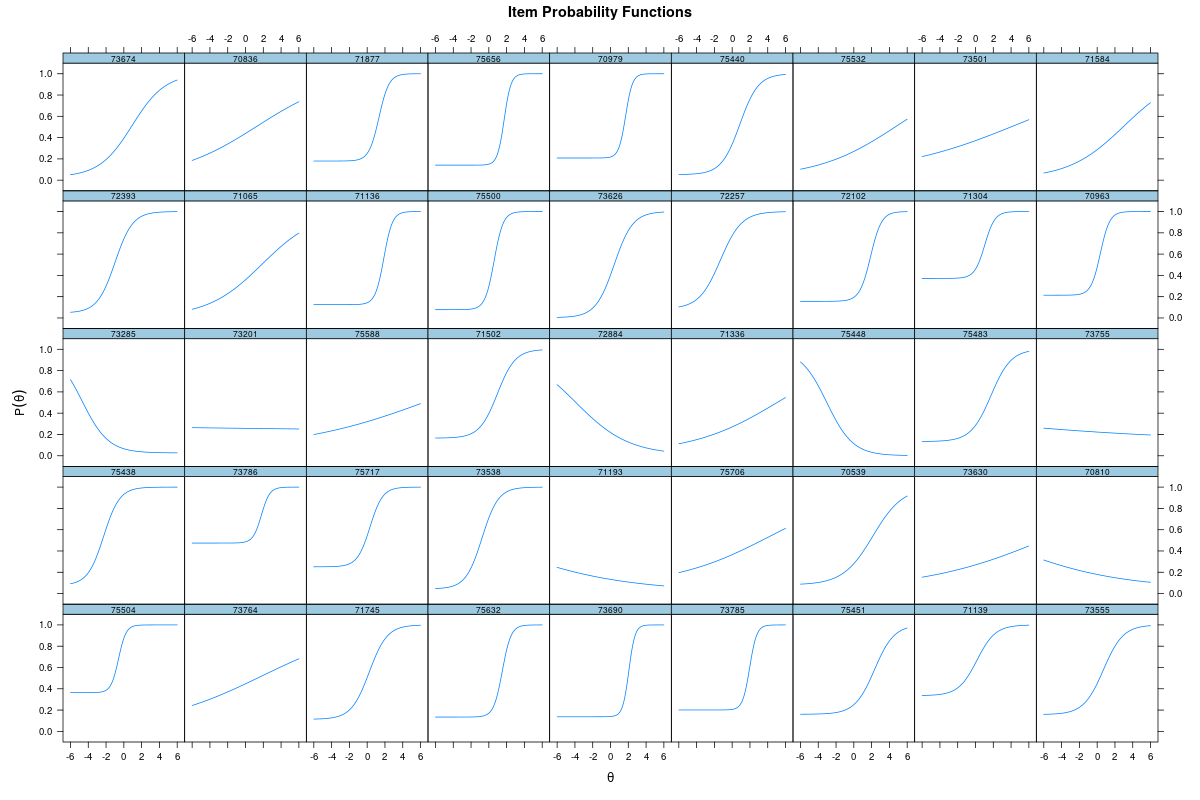

In [173]:
%%R -i model -w 1200 -h 800
plot(model,type="trace", facet_items=TRUE)

In [106]:
def calc_thetas(model,method="EAP"):
    thetas = mirt.fscores(model,method="EAP",full_scores=True,full_scores_SE=True)
    return to_df(thetas)[:,0], to_df(thetas)[:,1]

model = load_model(2022,'MT')
thetas,thetasse = calc_thetas(model)
thetasse

array([0.29003791, 0.59880601, 0.46667889, ..., 0.34895369, 0.50024662,
       0.62966006])

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='thetas1', ylabel='Count'>

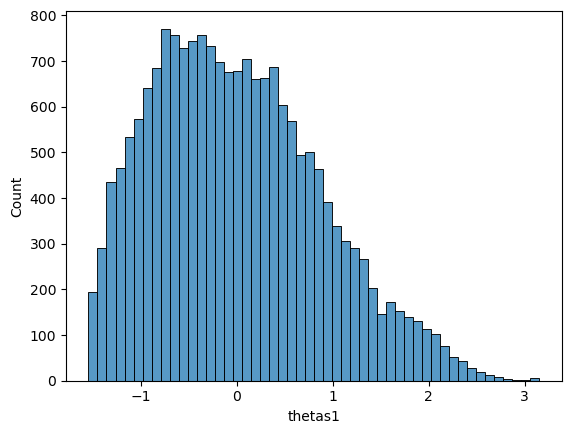

In [132]:
sns.histplot(df,x='thetas1')

In [133]:
df[['nota_inep','thetas1']].corr()

,nota_inep,thetas1
nota_inep,1.000000,0.993287
thetas1,0.993287,1.000000


/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Nota nosso modelo')

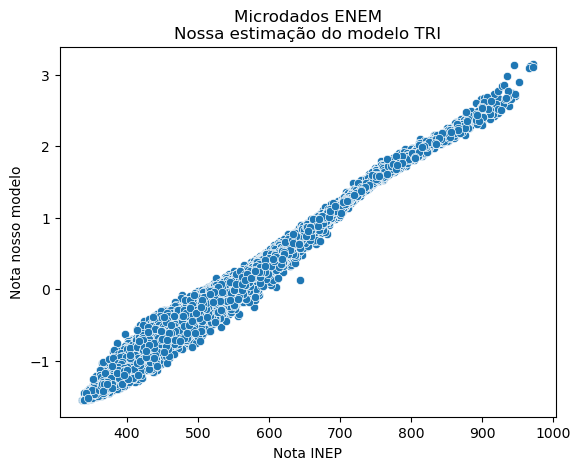

In [134]:
ax = sns.scatterplot(df,y='thetas1',x='nota_inep')
ax.set_title("Microdados ENEM\nNossa estimação do modelo TRI")
ax.set_xlabel("Nota INEP")
ax.set_ylabel("Nota nosso modelo")
#sns.scatterplot(df,x='acertos',y='theta3plmap')

## INEP Item coefficients 

In [39]:
def irt_coefs_inep(ano,area):
    df, resp, item_info = load_acertos(ano,area)
    resp.columns = resp.columns.astype(int)
    params = item_info[item_info["CO_ITEM"].isin(resp.columns)]
    if len(params) != len(resp.columns):
        print(f"Warning: params has length {len(params)} while resp has {len(resp.columns)} columns")
    params = params[["CO_ITEM","NU_PARAM_A","NU_PARAM_B","NU_PARAM_C"]]
    params = params.set_index("CO_ITEM")
    params.columns = ["a_inep","b_inep","c_inep"]
    return params
    

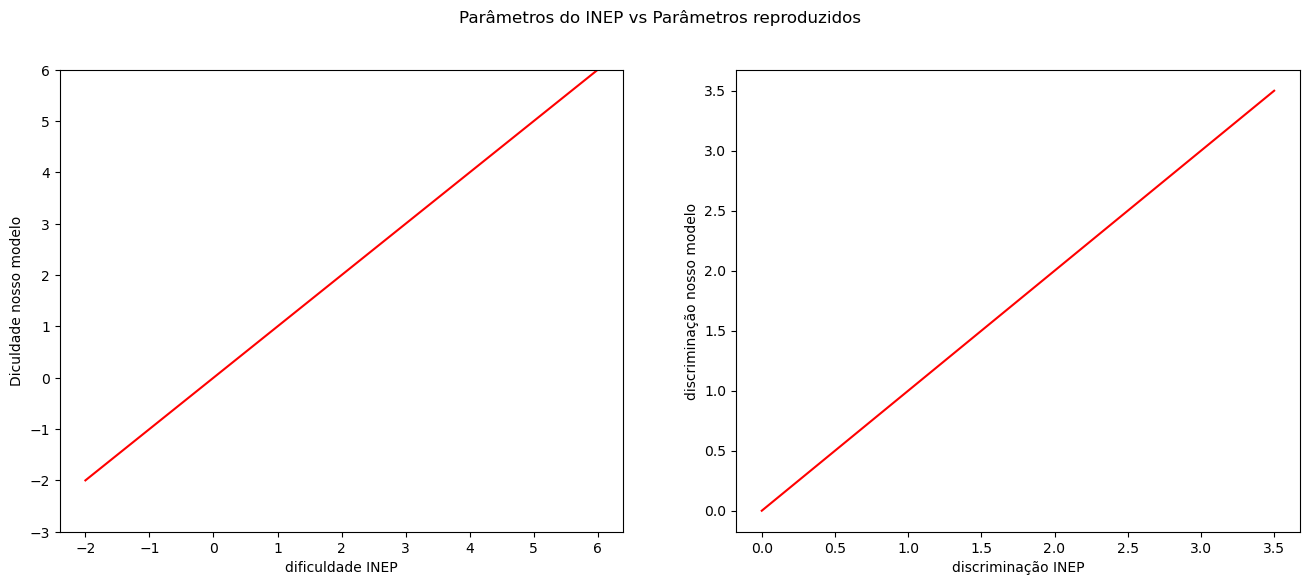

In [40]:
ano,area = 2014,'CN'

model = load_model(ano,area)
try:
    model6 = load_model(ano,area,remove_b=5)
except FileNotFoundError:
    model6 = model

coefs = irt_coefs(model)
coefs = coefs.join(item_stats(ano,area))
coefs6 = irt_coefs(model6)
coefs6 = coefs6.join(item_stats(ano,area))

#comp_coef = pd.merge(coefs,params,left_index=True,right_index=True)

fig, axs = plt.subplots(1,2,figsize=(16,6))
ax1,ax2 = axs[0],axs[1]
#plt.errorbar(comp_coef['d'],comp_coef['b'],yerr=comp_coef['b_se'],fmt='o')
ax1.scatter(coefs['NU_PARAM_B'],coefs['b'])
ax1.scatter(coefs6['NU_PARAM_B'],coefs6['b'])
ax1.plot([-2,6],[-2,6],'r')
ax1.set_ylim(-3,6)
fig.suptitle("Parâmetros do INEP vs Parâmetros reproduzidos")
ax1.set_ylabel("Diculdade nosso modelo");
ax1.set_xlabel("dificuldade INEP");
ax2.scatter(coefs['NU_PARAM_A'],coefs['a'])
ax2.scatter(coefs6['NU_PARAM_A'],coefs6['a'])
ax2.plot([0,3.5],[0,3.5],'r')
ax2.set_ylabel("discriminação nosso modelo");
ax2.set_xlabel("discriminação INEP");

<AxesSubplot:xlabel='ineptheta', ylabel='nota_inep'>

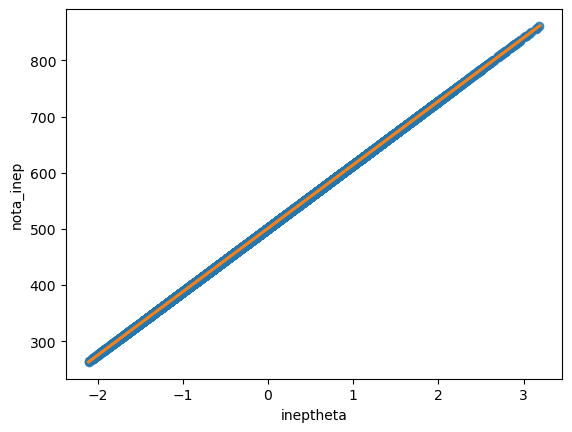

In [41]:
ano, area = 2009, 'CN'
inep_params = irt_coefs_inep(ano,area)
inep_params['u'] = 1 # a função generate_mirt_object abaixo requer 4 parâmetros para cada item.
# os itens devem corresponder aos das padrões de resposta dos candidatos (o variável resp abaixo).
inep_params = inep_params.sort_index() 
# transformar os parâmetros (essencialmente a da dificuldade) de IRT para "slope / intercept" do mirt.
inep_params = mirt.traditional2mirt(to_rdf(inep_params),"3PL")
mod_inep = mirtcat.generate_mirt_object(to_rdf(inep_params),itemtype = '3PL')
df, resp, item_info = load_acertos(ano,area)
resp.columns = resp.columns.astype(int)
resp = resp.sort_index(axis=1) # se não fizer isso, os itens (colunas nestas padrões de resposta) não correspondem ao modelo mod_inep acima
inepthetas= mirt.fscores(mod_inep,method="EAP",full_scores=True,returnER=False,verbose=True ,response_pattern = to_rdf(resp))
df['ineptheta'] = to_df(inepthetas)[:,0]
df['ineptheta_se'] = to_df(inepthetas)[:,1]

sns.regplot(df,x='ineptheta',y='nota_inep',ci=None,line_kws={"color": "C1"})
#plt.errorbar(df['ineptheta'],df['nota_inep'],xerr=df['ineptheta_se'],errorevery=100,ecolor='mediumblue',alpha=0.4)

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='nota_inep', ylabel='Count'>

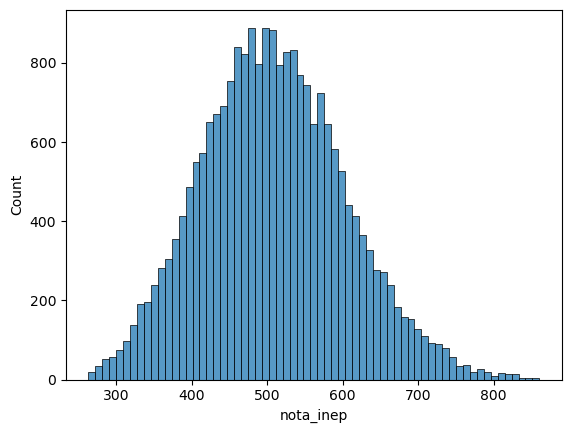

In [117]:
sns.histplot(df,x='nota_inep')

In [109]:
df.query('nota_inep > 800 & ineptheta < 0' )

,38545,61391,41659,32149,81583,33017,82507,26277,28143,49204,...,40302,62901,41816,39806,14712,acertos,caderno,nota_inep,ineptheta,ineptheta_se
candidato,,,,,,,,,,,,,,,,,,,,,
150005340871,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,1,12,243,803.7,-1.059353,0.651251


In [5]:
mt2015 = pd.read_csv('data/enem_1_2015.csv')
estranho = mt2015[mt2015['NU_INSCRICAO'] == 150005340871]

In [14]:
pd.set_option('display.max_rows', 500)
estranho.iloc[0]

NU_INSCRICAO                                                        150005340871
NU_ANO                                                                      2015
TP_FAIXA_ETARIA                                                                5
TP_SEXO                                                                        M
TP_ESTADO_CIVIL                                                              0.0
TP_COR_RACA                                                                    1
TP_NACIONALIDADE                                                               1
TP_ST_CONCLUSAO                                                                1
TP_ANO_CONCLUIU                                                                4
TP_ESCOLA                                                                      1
TP_ENSINO                                                                    NaN
IN_TREINEIRO                                                                   0
CO_MUNICIPIO_ESC            

In [103]:
df.sort_values('nota_inep')

,86767,30781,83741,111476,95820,96226,117692,117731,67554,37576,...,82880,117624,30420,27471,88461,acertos,caderno,nota_inep,ineptheta,ineptheta_se
candidato,,,,,,,,,,,,,,,,,,,,,
210051356897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,900,354.5,-1.122398,0.660463
210053209235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,901,354.7,-1.120953,0.660930
210053064883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,901,355.3,-1.116908,0.662459
210054121790,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,3,899,355.7,-1.113633,0.663414
210052304718,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,2,899,355.9,-1.111732,0.661090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210051992938,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,42,902,929.0,3.331365,0.348520
210051211845,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,43,900,934.2,3.380941,0.361232
210052099430,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,42,901,944.1,3.484358,0.386756


In [215]:
df.sort_values('ineptheta',ascending=False)

,60083,60084,60085,60086,60087,60088,60089,60090,59286,60091,...,60148,60149,60150,60151,60152,acertos,caderno,nota_inep,ineptheta,ineptheta_se
candidato,,,,,,,,,,,,,,,,,,,,,
100002587502,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,42,52,843.3,1.644379,0.619438
100003062333,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,1,38,51,831.4,0.935031,0.571748
100000330992,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,40,52,829.1,0.845564,0.550633
100003272416,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,40,49,825.7,0.765648,0.542858
100000559281,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,41,52,860.6,0.720816,0.542418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100003909430,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,6,50,393.3,-5.978028,0.068434
100001612769,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,4,52,285.3,-5.978115,0.068281
100000812717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,50,321.9,-5.978128,0.068259


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df[x],df[y])
print(slope,intercept)
df[x].std()

In [60]:
.71*112

79.52

<AxesSubplot:xlabel='acertos', ylabel='Count'>

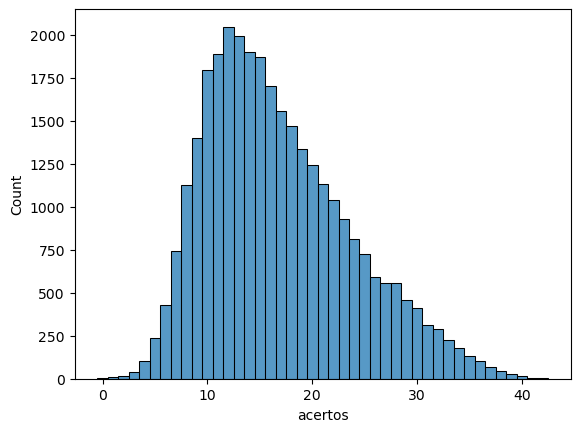

In [170]:
sns.histplot(df['acertos'],discrete=True)

<AxesSubplot:xlabel='inepthetas_eap', ylabel='inepthetasse_eap'>

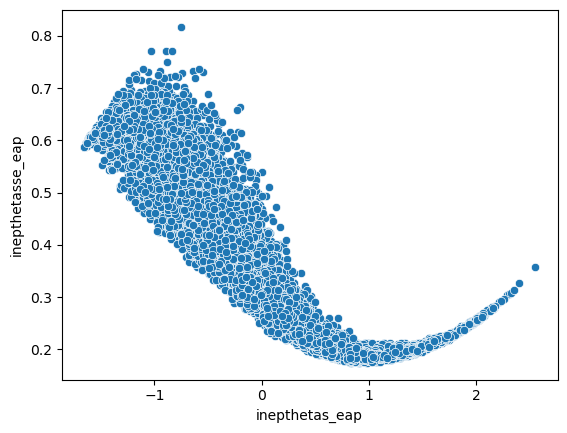

In [61]:
sns.scatterplot(df,x='inepthetas_eap',y='inepthetasse_eap')

Text(0.5, 1.0, 'Reprodução das notas do ENEM 2019\na partir do microdados')

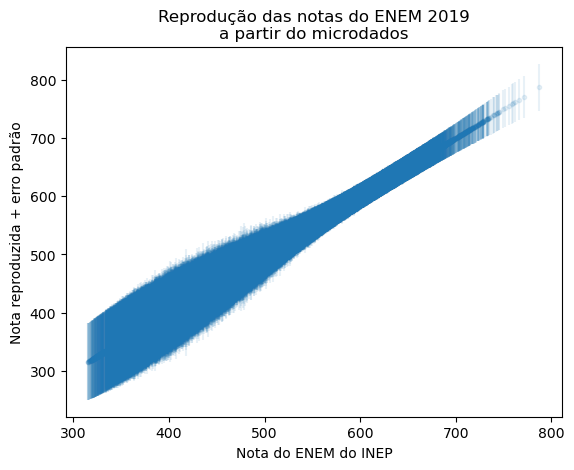

In [64]:
plt.errorbar(df['nota_inep'],df[x]*slope+intercept,yerr=df[xs]*slope,fmt=".",alpha=0.1)
ax = plt.gca()
ax.set_xlabel("Nota do ENEM do INEP")
ax.set_ylabel("Nota reproduzida + erro padrão")
ax.set_title("Reprodução das notas do ENEM 2019\na partir do microdados");


<AxesSubplot:xlabel='inepthetas_eap'>

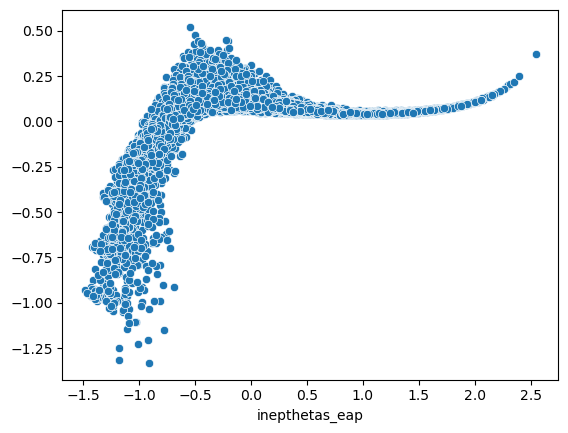

In [188]:
sns.scatterplot(x=df['inepthetas_eap'],y=(df['inepthetas_ml']-df['inepthetas_eap']))

In [46]:
resp0 = resp.iloc[0:10]
resp0

,86751,83820,77940,118034,84811,96447,96302,111820,118033,84769,...,118054,66498,88308,87709,112135,81689,97975,118108,66219,111877
0,0,1,1,0,0,1,0,0,1,0,...,1,1,0,0,1,0,0,1,0,0
1,0,1,0,0,1,0,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0
2,0,1,1,0,1,1,0,0,0,1,...,0,1,1,0,1,0,0,1,0,1
3,0,1,1,0,1,1,1,0,0,1,...,0,1,0,0,0,0,0,1,0,1
4,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,1,0
5,0,1,1,0,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,1,1
6,0,1,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,0,0,0
8,0,1,1,0,1,1,1,0,1,1,...,0,1,0,1,1,0,1,1,1,0
9,0,1,1,1,0,1,1,0,1,0,...,0,1,1,0,1,1,0,1,0,0


In [52]:
%%R -i mod_inep,resp0,resp,model3pl
respvec <- rep(0,43)
fscores(mod_inep,method="EAP",full.scores=TRUE,full.scores_SE = TRUE,verbose=TRUE,response.pattern = respvec)

            F1     SE_F1
[1,] -1.653506 0.5867472


In [68]:
respvec = [1]*43

In [71]:
mirt.fscores(mod_inep,method="EAP",full_scores=True, full_scores_SE = True,verbose=True ,response_pattern = to_rdf(respvec))


2.9936527317926926,0.4641611263840843
